# Part 1: Introduction

In this notebook, we determine on extracting key features of galaxy based on the question tree diagram from Hart et al. (2016). The final goal is to train and compare the accuracy of classification models learnt from our extracted features vs from the morphology measurement Table 1 (Hart et al. 2016).

# Part 2: Set up Libraries

In [1]:
import os
from pathlib import Path
import pandas as pd

import numpy as np
import math
import cv2 as cv2
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from skimage.morphology import (erosion, dilation, opening, closing, skeletonize, convex_hull_image, medial_axis)
from skimage.morphology import diamond
from skimage.filters import threshold_multiotsu
from skimage.measure import label, regionprops, regionprops_table

from sklearn.cluster import KMeans
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.display import FileLink

# Part 3: Define Function

In [4]:
def find_main_galaxy_center(image, crop_x_ratio=0.5, crop_y_ratio=0.5, num_brightest_pixels=100, plot=False):
    """
    Crop and Find the center of the main galaxy in a grayscale image.
    """
    # Get the dimensions of the image
    height, width = image.shape

    # Define the cropped region
    crop_height = int(height * crop_y_ratio)
    crop_width = int(width * crop_x_ratio)
    start_y = (height - crop_height) // 2
    start_x = (width - crop_width) // 2
    cropped_image = image[start_y:start_y+crop_height, start_x:start_x+crop_width]

    # Flatten the cropped image to find the brightest pixels
    flat_image = cropped_image.flatten()
    
    # Get the indices of the brightest pixels
    brightest_indices = np.argpartition(flat_image, -num_brightest_pixels)[-num_brightest_pixels:]

    # Convert the flat indices to 2D coordinates within the cropped region
    brightest_coords = np.array(np.unravel_index(brightest_indices, cropped_image.shape)).T

    # Calculate the mean coordinates of the brightest pixels
    mean_coords = np.mean(brightest_coords, axis=0)

    # New center coordinates
    center_y = mean_coords[0]
    center_x = mean_coords[1]
    
    # Old center coordinates
    old_center_y = mean_coords[0] + start_y
    old_center_x = mean_coords[1] + start_x
    
    if plot == True:
        # Plot the cropped image and mark the center pixel
        print(f"Center of the main galaxy (cropped): (x: {center_y}, y: {center_x})")
        plt.figure()
        plt.imshow(cropped_image)
        plt.colorbar()
        plt.scatter(center_x, center_y, color='red', marker='x')
        plt.title(f"Cropped Image with Center of Main Galaxy")
        plt.show()

        # Plot the original image and mark the center pixel
        print(f"Center of the main galaxy: (x: {center_y}, y: {center_x})")
        plt.figure()
        plt.imshow(image)
        plt.colorbar()
        plt.scatter(old_center_x, old_center_y, color='blue', marker='x')
        plt.title(f"Image with Center of Main Galaxy")
        plt.show()
    
    return cropped_image, center_x, center_y, old_center_x, old_center_y

In [5]:
def multithreshold(image, adj_thre0 = 0, adj_thre1 = 0, adj_thre2 = 0, plot=False):
    """
    Generate binary image with Clahe thresholding
    """
    # Apply MultiOtsu thresholding of the Clahe
    image_thresh = threshold_multiotsu(image, classes=4)
    image_thresh[0] += adj_thre0
    image_thresh[1] += adj_thre1
    image_thresh[2] += adj_thre2

    # Using the threshold values, we generate the 3 regions.
    regions = np.digitize(cla_img, bins=image_thresh)
    
    # Select only 2 brightest regions
    in_regions = regions == 2
    cen_regions = regions == 3
    
    
    if plot == True:
        print(f"\nThresholds: {image_thresh}\n")
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.5))

        # Plotting the CLAH image.
        ax[0].imshow(image)
        ax[0].set_title('Before thresholding')
        ax[0].axis('off')

        # Plotting the histogram and the two thresholds obtained from multi-Otsu.
        ax[1].hist(image.ravel(), bins=255)
        ax[1].set_title('Histogram')
        for thresh in image_thresh:
            ax[1].axvline(thresh, color='r')

        # Plotting the Multi Otsu result.
        ax[2].imshow(regions, cmap='jet')
        ax[2].set_title('Multi-Otsu result')
        ax[2].axis('off')

        plt.subplots_adjust()
        plt.show()
    
    return in_regions, cen_regions

In [6]:
def K_clustering(image, k=3, xc=60.0, yc=60.0, plot=False):
    """
    Galaxy region segmentation to binary image
    """
    # Get the dimensions of the image
    height, width = image.shape

    # Step 2: Create a dataframe with x, y coordinates and pixel values
    data = []

    for y in range(height):
        for x in range(width):
            pixel_value = image[y, x]
            data.append([x, y, pixel_value])
    df = pd.DataFrame(data, columns=['x', 'y', 'pixel_value'])

    # Step 3: Apply k-means clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)

    # Get the cluster labels
    labels = kmeans.labels_

    # Reshape the labels to match the image shape
    clustered_image = labels.reshape(height, width)
    
    # Identify the cluster of the given pixel and 
    # Create binary image for the desired class
    selected_cluster = clustered_image[int(round(yc)), int(round(xc))]
    binary_image = (clustered_image == selected_cluster).astype(np.uint8) * 255
    
    if plot == True:
        # Plot the original and clustered images
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f"Clustered Image with k={k}")
        plt.imshow(clustered_image, cmap='gray')

        plt.show()

        # Show the binary image
        plt.figure(figsize=(10, 5))
        plt.imshow(binary_image, cmap='gray')
        plt.title(f"Binary Image for the cluster containing the main galaxy")
        plt.show()

    return binary_image

## Preprocessing

In [7]:
def noise_reduce(image, plot=False):
    """
    Apply median filtering for Noise reduction
    """
    cutout_blur = cv2.medianBlur(np.array(image, dtype = 'uint8'), 11)
    
    if plot==True:
        plt.figure()
        plt.imshow(cutout_blur) 
        plt.title("Cut out and blurred")
        plt.colorbar()
        plt.show()
    
    return cutout_blur

In [8]:
def hist_equal(image, adj_bright = -5, plot=False):
    """
    Apply CLAHE histogram Equalization
    """
    # The declaration of CLAHE
    # clipLimit -> Threshold for contrast limiting
    adjust_brightness = adj_bright # some const to adjust brightness after CLAHE
    clahe = cv2.createCLAHE(clipLimit=5)
    cla_img = clahe.apply(image) + adjust_brightness

    if plot==True:
        print(f"Clahe shape, min, max: {cla_img.shape}, {np.min(cla_img)}, {np.max(cla_img)}")

        # Plotting the image after CLAHE
        plt.figure()
        plt.imshow(cla_img) 
        plt.title("CLAHE")
        plt.colorbar()

        # Plotting the histogram after CLAHE
        plt.figure()
        plt.hist(cla_img.ravel(), bins=255)
        plt.title('Histogram')

        plt.show()

    return cla_img

## Post-processing

In [9]:
def morph(image, plot=False):
    """
    Apply opening in morphology to eliminate small artifacts outside
    """
    mor_img0 = erosion(image, diamond(2))
    mor_img1 = dilation(mor_img0, diamond(2))
    
    if plot == True:
        plt.figure()
        plt.imshow(mor_img0) 
        plt.title("Morphology erosion applied")
        plt.colorbar()

        plt.figure()
        plt.imshow(mor_img1) 
        plt.title("Morphology dilation applied")
        plt.colorbar()
        plt.show()
    
    return mor_img1

## Feature extraction

In [10]:
def external_descriptor(binary_image, image, plot=False): 
    """
    Extract external descriptors of galaxy
    """
    # Region property
    label_img = label(binary_image)
    regions = regionprops(label_img)
    
    props = regions[0]
    
    # Area: number of pixels of the region scaled by pixel-area
    Area = int(props.area)
    # Perimeter: approximates the contour as a line through the centers of border pixels using a 4-connectivity
    Perimeter = int(props.perimeter)
    # Orientation
    Orientation = int(props.orientation)
    # Eccentricity
    Eccentricity = props.eccentricity
    # Solidity: Ratio of pixels in the region to pixels of the convex hull image.
    Solidity = props.solidity
    
    info = [Area, Perimeter, Orientation, Eccentricity, Solidity]

    # Illustrate the region
    if plot == True: 
        print(f"Area, Perimeter, Orientation, Eccentricity, Solidity: {info[0]}, {info[1]}, {info[2]}, {info[3]}, {info[4]}")
        
        plt.imshow(binary_image, cmap='gray')
        plt.title('Binarize image')
        fig, ax = plt.subplots()
        ax.imshow(image, cmap=plt.cm.gray)

        for props in regions:
            y0, x0 = props.centroid
            orientation = props.orientation
            x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
            y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
            x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
            y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

            ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=15)

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax.plot(bx, by, '-b', linewidth=2.5)

        plt.show()
    
    return info

### Applications of morphology

Hit(S): white, Miss(T): red


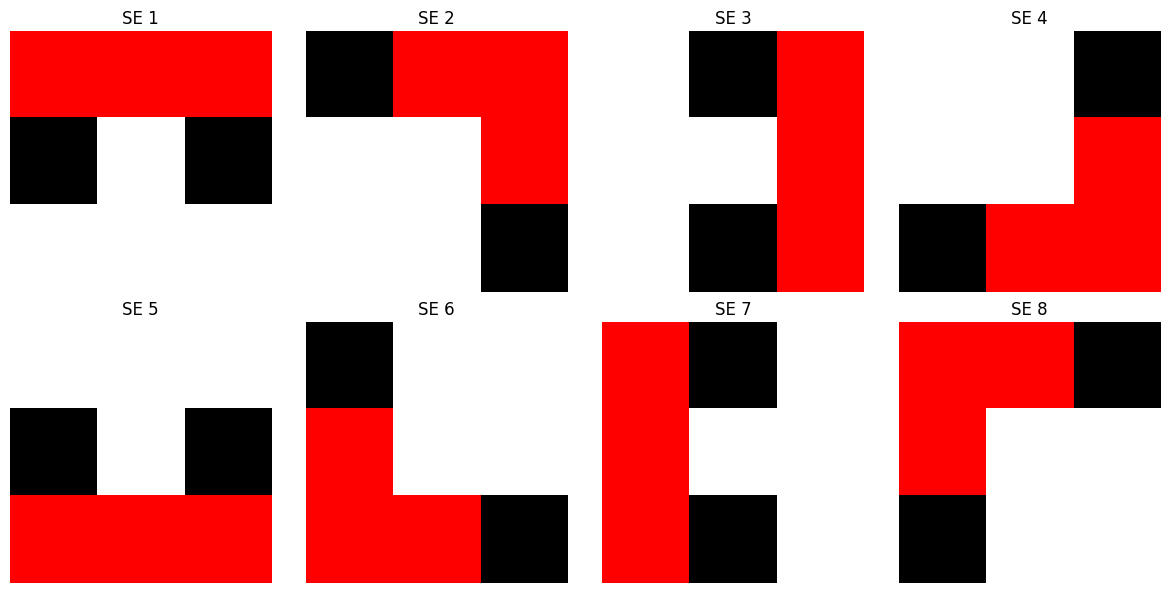

In [11]:
def plot_structuring_elements(structuring_elements):
    """
    Plot each structuring element pair with S_i in white and T_i in red.
    """
    print('Hit(S): white, Miss(T): red')
    numSE = int(len(structuring_elements)/2)
    fig, axes = plt.subplots(2, numSE, figsize=(12, 6))
    axes = axes.ravel()
        
    for idx, pix in enumerate(structuring_elements):
        # Create an image to show S_i in white and T_i in red
        visualization = np.zeros((3, 3, 3), dtype=np.uint8)
        # S_i in white
        visualization[pix == 1] = [255, 255, 255]
        # T_i in red
        visualization[pix == -1] = [255, 0, 0]
        # Plot the structuring element pair
        axes[idx].imshow(visualization)
        axes[idx].set_title(f'SE {idx + 1}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
    
# Define structuring elements for thinning
structuring_elements = [
    (np.array([[-1, -1, -1], 
               [ 0,  1,  0], 
               [ 1,  1,  1]], dtype=np.int8)),
    (np.array([[0, -1, -1], 
               [1,  1, -1], 
               [1,  1,  0]], dtype=np.int8)),
    (np.array([[1,  0, -1], 
               [1,  1, -1], 
               [1,  0, -1]], dtype=np.int8)),
    (np.array([[1,  1,  0], 
               [1,  1, -1], 
               [0, -1, -1]], dtype=np.int8)),
    (np.array([[1,   1,  1], 
               [0,   1,  0], 
               [-1, -1, -1]], dtype=np.int8)),
    (np.array([[ 0,  1,  1], 
               [-1,  1,  1], 
               [-1, -1,  0]], dtype=np.int8)),
    (np.array([[-1, 0, 1], 
               [-1, 1, 1], 
               [-1, 0, 1]], dtype=np.int8)),
    (np.array([[-1, -1, 0], 
               [-1,  1, 1], 
               [ 0,  1, 1]], dtype=np.int8)),
]
# Plot structuring elements
plot_structuring_elements(structuring_elements)

In [12]:
# Thinning and Skeletonizing using morphology

def mor_thin(binary_image, SE):
    """
    Perform morphological thinning on image using structuring element
    """
    hitmiss_result = cv2.morphologyEx(binary_image, cv2.MORPH_HITMISS, SE)
    image_thin = cv2.bitwise_and(binary_image, cv2.bitwise_not(hitmiss_result))

    return image_thin

def mor_iter_thin(image, structuring_elements, max_iterations=200, plot=False):
    """
    Perform iterative thinning on image using a list of structuring elements.
    """
    # Binarize image
    binary_image = cv2.threshold(image.astype("uint8"), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] 
    
    # Thinning
    thinned = binary_image.copy()
    prev_thinned = np.zeros_like(binary_image) 
    iteration = 0
    
    while not np.array_equal(thinned, prev_thinned) and iteration < max_iterations:
        prev_thinned = thinned.copy()
        for SE in structuring_elements:
            thinned = mor_thin(thinned, SE)
            
        iteration += 1
        
    if plot==True:
        plt.figure()
        plt.subplot(211)
        plt.imshow(binary_image)
        plt.title('Input binary image')
        plt.subplot(212)
        plt.imshow(thinned)
        plt.title('Thinning')
    
    return thinned, iteration

In [13]:
# Find connected components using morphology

def mor_connect(image, min_area = 1, max_area = 200, plot=False):
    """
    Find connected components using morphology
    """
    # Initialize a new image to store all the output components 
    output = np.zeros(image.shape, dtype="uint8")
    
    # Connected component labeling and analysis
    analysis = cv2.connectedComponentsWithStats(np.uint8(image), 4, cv2.CV_32S) 
    (totalLabels, label_ids, values, centroid) = analysis 
    displayCount = 0
    
    # Loop through each component
    for i in range(1, totalLabels):            
        # Area of the component
        area = values[i, cv2.CC_STAT_AREA]
        if (area > min_area) and (area < max_area): 
            # Create a mask for the component
            componentMask = (label_ids == i).astype("uint8") * 255
            
            # Represent filtered results
            output = cv2.bitwise_or(output, componentMask) 
            
            displayCount += 1
    
    if plot == True:
        print(f"Total components: {totalLabels}")
        print(f"Filtered components: {displayCount}")
        # Display the result
        plt.figure(figsize=(15,10))
        plt.subplot(211)
        plt.imshow(image)
        plt.title('Input binary image')
        plt.subplot(212)
        plt.imshow(output)
        plt.title('Filtered Components')
        plt.show()
    
    return analysis, displayCount

## Mass processing

In [14]:
def Primary_Feature(cutout_image, xc, yc):
    """
    Measure Area, Perimeter, Orientation, Eccentricity, Solidity
    """
    ## Inspect clustering
    bi_img = K_clustering(cutout_image, k=3, xc=xc, yc=yc, plot=False)
    ## Measure 
    info = external_descriptor(bi_img, cutout_img, plot=False)
    
    return info


def Special_Feature(cutout_image):
    """
    Determine if there is any galaxy arm, number of center by segmentating bright region
    """
    ## Preprocessing
    ### Noise reduction
    cutout_blur = noise_reduce(cutout_image, plot=False)
    ### Apply CLAHE histogram Equalization
    cla_img = hist_equal(cutout_blur, adj_bright = -5, plot=False)

    ## Re-segmentate each region to binary images based on brightness
    in_regions, cen_regions = multithreshold(cla_img, adj_thre0=50, adj_thre1=50, adj_thre2=60, plot=False)

    ## Post-processing
    ### Reduce small bright artifacts from the thresholding
    mor_img_in = morph(in_regions, plot=False)
    mor_img_cen = morph(cen_regions, plot=False)
    ### Perform iterative thinning for inner region (galaxy arms)
    thinned_img, _ = mor_iter_thin(mor_img_in, structuring_elements, max_iterations=2, plot=False)

    ## Count connected components
    ### Count bright components surrounding center (arms (>2), smooth elliptical (~1))
    _, filterLabels_in = mor_connect(thinned_img, min_area=100, max_area=3000, plot=False)
    ### Count centers (merger (>1))
    _, filterLabels_cen = mor_connect(mor_img_cen, min_area=50, max_area=3000, plot=False)
    
    return filterLabels_in, filterLabels_cen


In [15]:
def process_images(path_jpg_series):
    galaxy_info = []
    for idx, path in enumerate(path_jpg_series):
        # Filename
        filename = path.replace('/kaggle/input/galaxy-zoo-2-images/images_gz2/images/', '')
        filename = filename.replace('.jpg','')
        
        # Read each image
        img = cv2.imread(path,0).astype(float)
        
        # Segmentate to galaxy region and return center coordinates
        cutout_img, xc, yc, old_xc, old_yc = find_main_galaxy_center(img, crop_x_ratio=0.29, crop_y_ratio=0.29, num_brightest_pixels=100)
        
        # Extract Primary features from the K-mean clustering segmentation
        info = Primary_Feature(cutout_img, xc, yc)
        
        # Extract Special features
        num_bright, num_center = Special_Feature(cutout_img)
        
        ## Save filename and descriptors
        Feature = {}
        Feature["FileName"] = str(filename)
        Feature["K_Area"] = str(info[0]) 
        Feature["K_Perimeter"] = str(info[1])
        Feature["K_Orientation"] = str(info[2])
        Feature["K_Eccentricity"] = str(info[3])
        Feature["K_Solidity"] = str(info[4]) 
        
        Feature["Num_bright"] = str(num_bright)
        Feature["Num_center"] = str(num_center)
        
        galaxy_info.append(Feature)
        
    df = pd.DataFrame(galaxy_info)
    
    return df

# Part 4: Set up Data

## Path to images (optional, for visualizarion only)

In [16]:
path_IMG = Path('/kaggle/input/galaxy-zoo-2-images/images_gz2/images')

In [17]:
path_jpg = list(path_IMG.glob(r"*.jpg"))

In [18]:
path_jpg_series = pd.Series(path_jpg,name="JPG").astype(str)

In [19]:
print(path_jpg_series)

0         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
1         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
2         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
3         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
4         /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
                                ...                        
243429    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243430    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243431    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243432    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
243433    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
Name: JPG, Length: 243434, dtype: object


In [20]:
print(path_jpg_series[0])

/kaggle/input/galaxy-zoo-2-images/images_gz2/images/64601.jpg


In [21]:
len(path_jpg_series)

243434

## Path to mapping table for 1000 samples (use later)

In [22]:
mapping = pd.read_csv('/kaggle/input/mini-gz2-hart16-mapping-1000samples-7classes/mini_1000s_7c_gz2_hart16_mapping.csv')

In [23]:
mapping.count()

dr7objid                                           1000
ra                                                 1000
dec                                                1000
rastring                                           1000
decstring                                          1000
                                                   ... 
t11_arms_number_a37_cant_tell_fraction             1000
t11_arms_number_a37_cant_tell_weighted_fraction    1000
t11_arms_number_a37_cant_tell_debiased             1000
t11_arms_number_a37_cant_tell_flag                 1000
asset_id                                           1000
Length: 231, dtype: int64

In [24]:
mapping.head(10)

,dr7objid,ra,dec,rastring,decstring,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,...,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag,asset_id
0,588010879833997510,182.711990,5.422132,12:10:50.88,+05:25:19.7,Ei,45,140,42,42.000000,...,0.00,0.000000,0,0,0.0,0.0,0.0,0.000000,0,198489
1,587738946673639494,155.950653,35.693974,10:23:48.16,+35:41:38.3,Ei,44,150,36,36.000000,...,0.00,0.000000,0,0,0.0,0.0,0.0,0.000000,0,115111
2,588017703489241485,230.746307,8.664599,15:22:59.11,+08:39:52.6,Ei,44,137,40,40.000000,...,0.00,0.000000,0,0,0.0,0.0,0.0,0.000000,0,217599
3,587728880341876898,157.747604,4.589555,10:30:59.42,+04:35:22.4,Ei,41,138,38,38.000000,...,0.00,0.000000,0,0,0.0,0.0,0.0,0.000000,0,248585
4,587733079742283987,196.365067,53.699623,13:05:27.62,+53:41:58.6,Ei,39,149,29,29.000000,...,0.25,0.265916,0,2,2.0,0.5,0.5,0.481610,0,63958
5,588017721177669716,171.840225,41.833324,11:27:21.65,+41:49:60.0,Ei,43,146,37,37.000000,...,0.00,0.000000,0,1,1.0,1.0,1.0,1.000000,1,220510
6,588017115053228178,212.698410,43.607502,14:10:47.62,+43:36:27.0,Ei,42,131,38,38.000000,...,0.00,0.000000,0,0,0.0,0.0,0.0,0.000000,0,208897
7,587732134839648365,151.198700,46.719341,10:04:47.69,+46:43:09.6,Ei,43,134,38,38.000000,...,0.00,0.000000,0,0,0.0,0.0,0.0,0.000000,0,51437
8,587731521201570005,124.391792,34.710365,08:17:34.03,+34:42:37.3,Ei,47,156,39,38.540001,...,0.00,0.000000,0,0,0.0,0.0,0.0,0.000000,0,44597
9,588017712049356987,211.185440,49.155872,14:04:44.51,+49:09:21.1,Ei,44,147,38,38.000000,...,0.00,0.000000,0,1,1.0,0.5,0.5,0.447212,0,219546


In [25]:
filtering = mapping['asset_id']

In [26]:
type(filtering)

pandas.core.series.Series

In [27]:
filtering.head(10)

0    198489
1    115111
2    217599
3    248585
4     63958
5    220510
6    208897
7     51437
8     44597
9    219546
Name: asset_id, dtype: int64

In [28]:
filtering.count()

1000

## Rename names to path to keep only 1000 samples path to images

In [29]:
# Define the prefix and suffix
prefix = '/kaggle/input/galaxy-zoo-2-images/images_gz2/images/'
suffix = '.jpg'

# Add the prefix and suffix to each image name
filtered_paths = filtering.apply(lambda x: f"{prefix}{x}{suffix}")

In [30]:
print(filtered_paths)

0      /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
1      /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
2      /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
3      /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
4      /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
                             ...                        
995    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
996    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
997    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
998    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
999    /kaggle/input/galaxy-zoo-2-images/images_gz2/i...
Name: asset_id, Length: 1000, dtype: object


In [31]:
len(filtered_paths)

1000

## Visualize

Note: use cv2 or plt will give different color visualization (cv2: BGR, plt: RGB)

Text(0.5, 1.0, '30154.jpg')

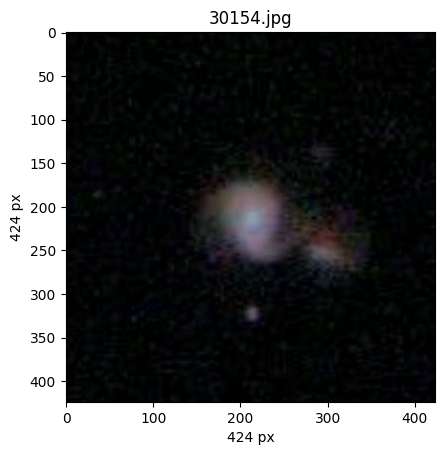

In [32]:
# Read an image
path = '/kaggle/input/galaxy-zoo-2-images/images_gz2/images/'
name_img = '30154'+'.jpg'
img = cv2.imread(path+name_img)

# Plot
plt.imshow(img)
plt.xlabel("{} px".format(img.shape[1]))
plt.ylabel("{} px".format(img.shape[0]))
plt.title(name_img)

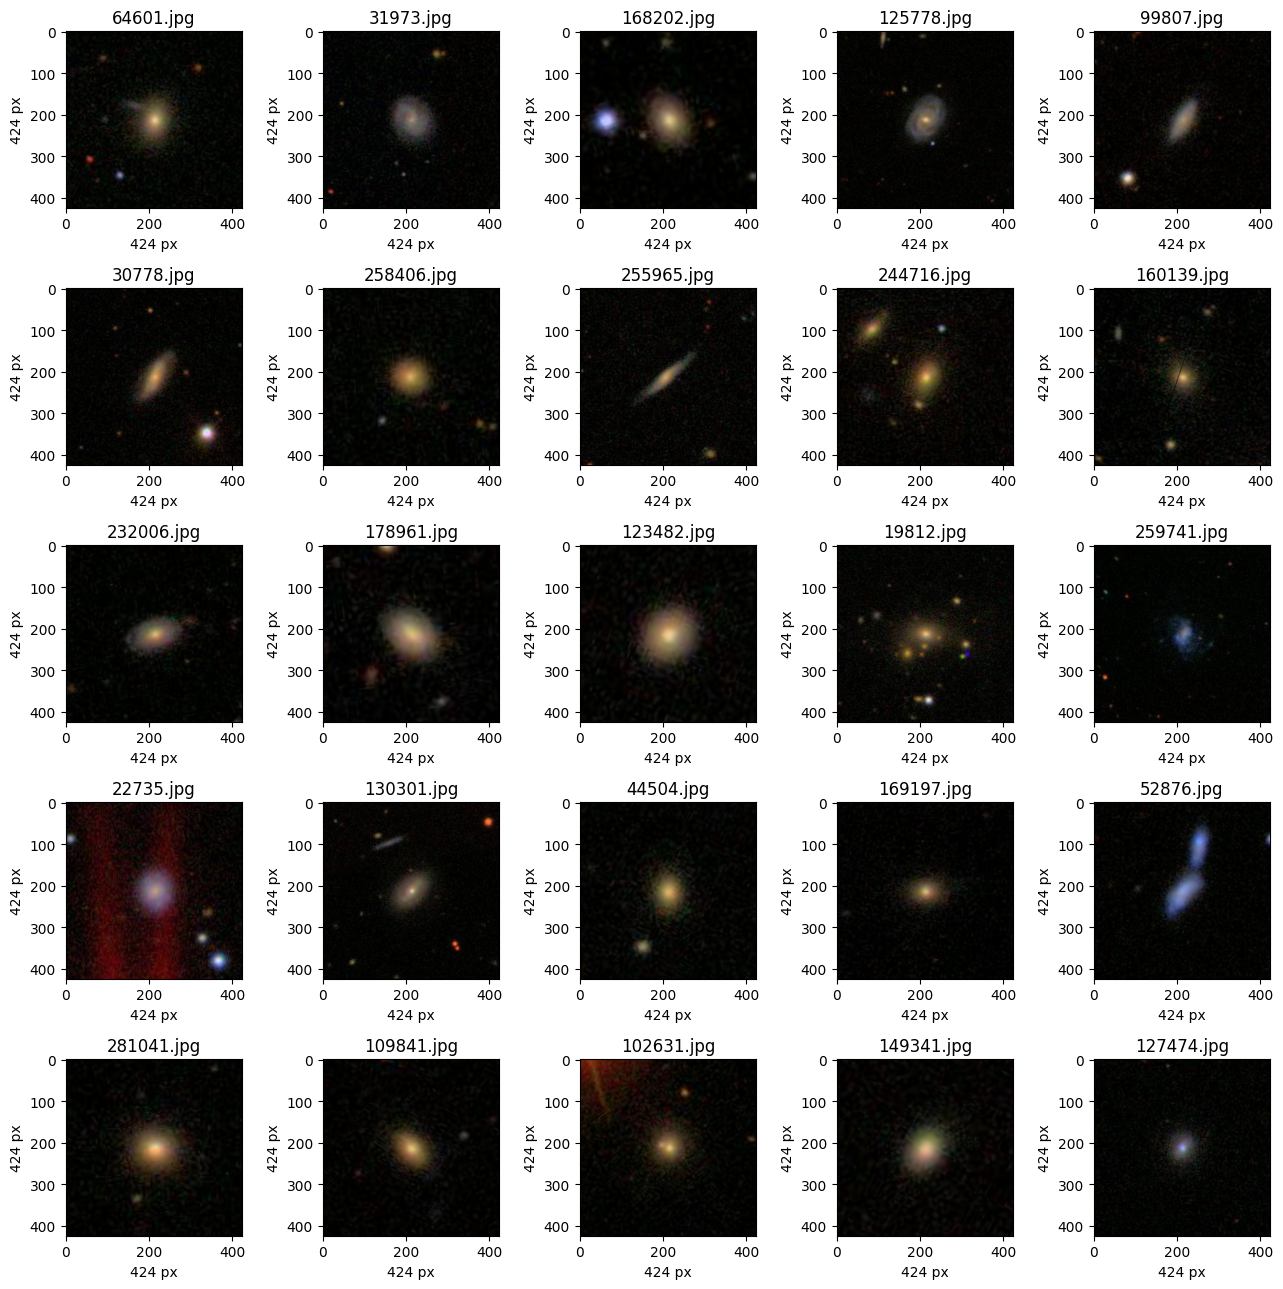

In [33]:
# Plot 25 galaxies
figure,axes = plt.subplots(nrows=5,ncols=5,figsize=(13,13))
for i,ax in enumerate(axes.flat):
    imgs = plt.imread(path_jpg_series[i])
    name_imgs = path_jpg_series[i].replace('/kaggle/input/galaxy-zoo-2-images/images_gz2/images/', '')
    ax.imshow(imgs)
    ax.set_xlabel("{} px".format(imgs.shape[1]))
    ax.set_ylabel("{} px".format(imgs.shape[0]))
    ax.set_title(name_imgs)
plt.tight_layout()
plt.show()

# Part 4: Feature Extraction

Based on the Question tree diagram in Hart et al. (2016), the features should be:

- Simple descriptors: Area, Perimeter, Orientation, Eccentricity, Solidity, …
- Special features: Spiral arms, Merger,...

## 4.1 Example on 1 galaxy

SEGMENTATION
Center of the main galaxy (cropped): (x: 61.63, y: 62.38)


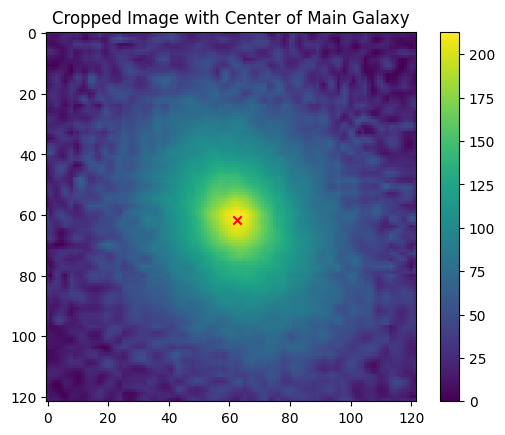

Center of the main galaxy: (x: 61.63, y: 62.38)


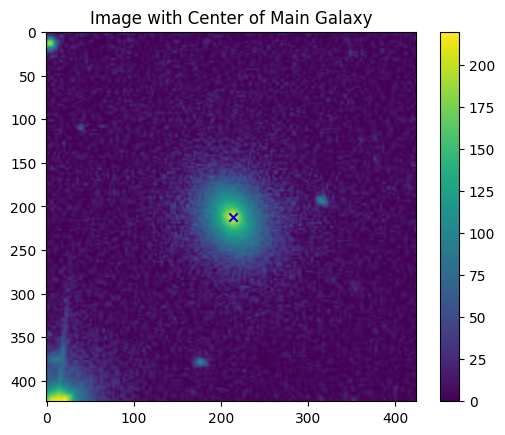


EXTERNAL DESCRIPTOR



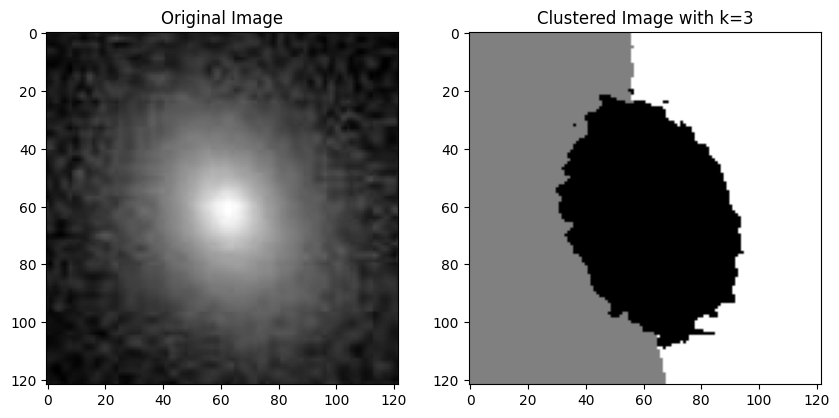

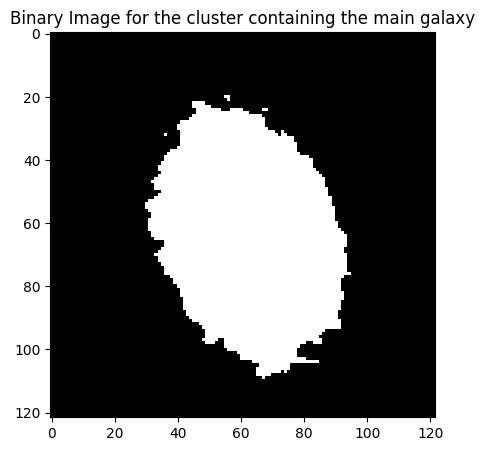

Area, Perimeter, Orientation, Eccentricity, Solidity: 3, 3, 0, 0.816496580927726, 1.0


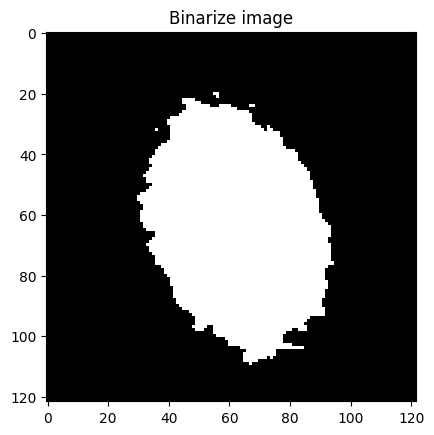

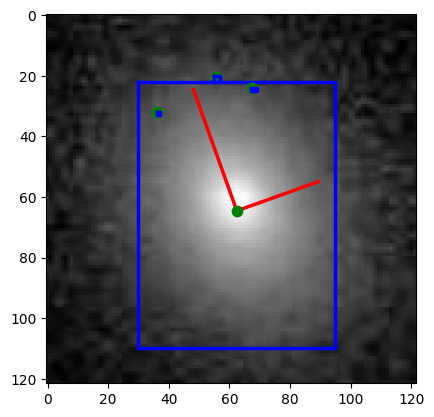


INTERNAL DESCRIPTOR



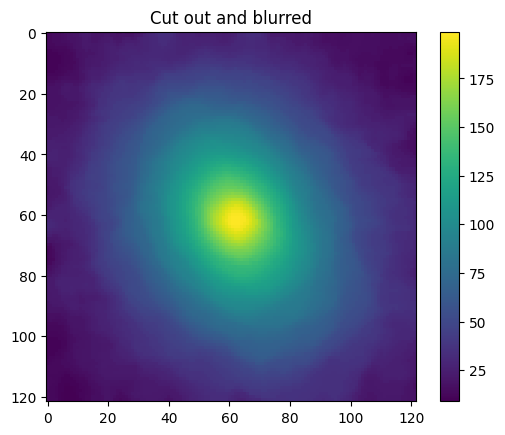

Clahe shape, min, max: (122, 122), 8, 246


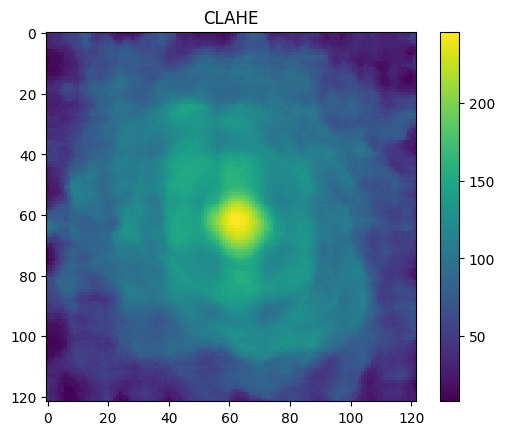

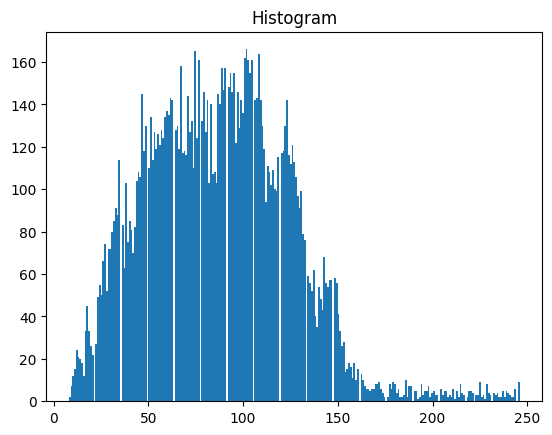


Thresholds: [116 156 222]



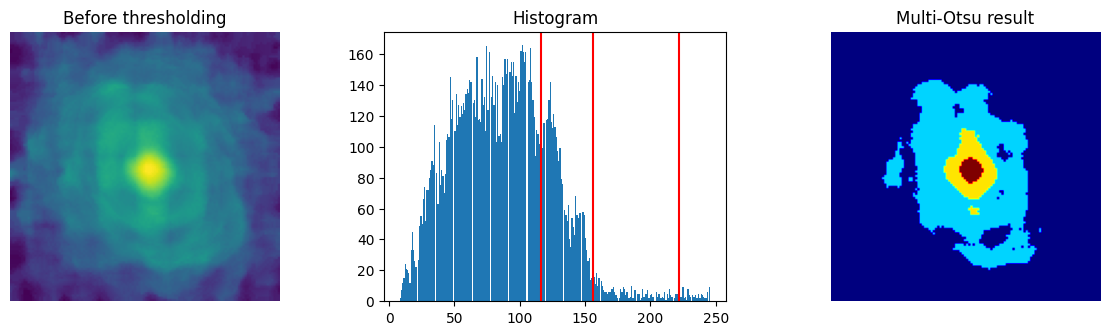

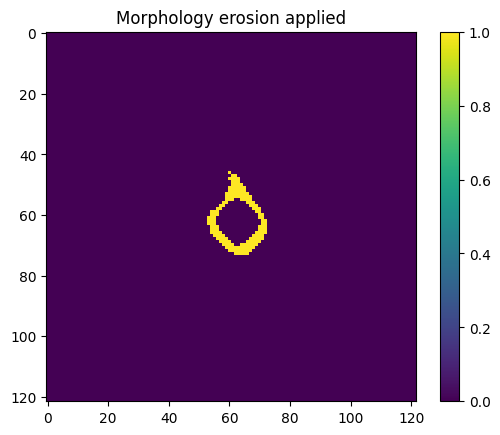

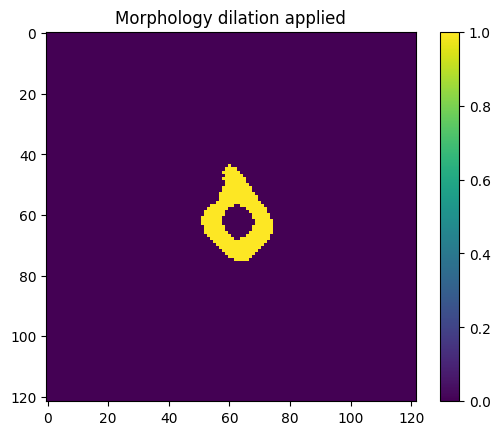

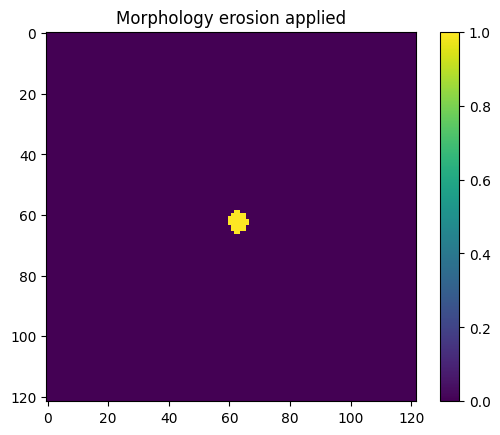

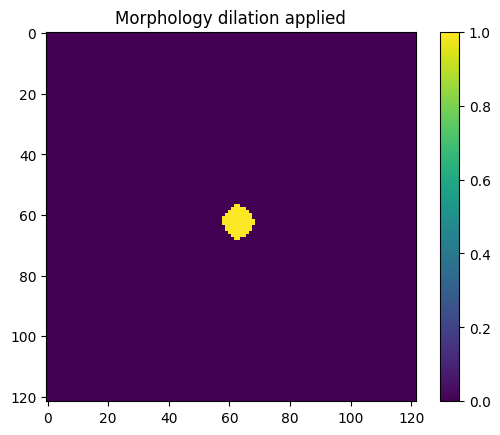

Total components: 2
Filtered components: 1


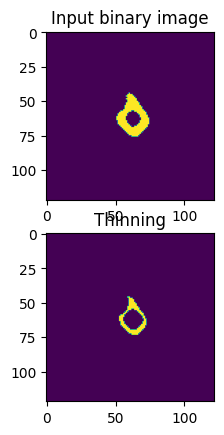

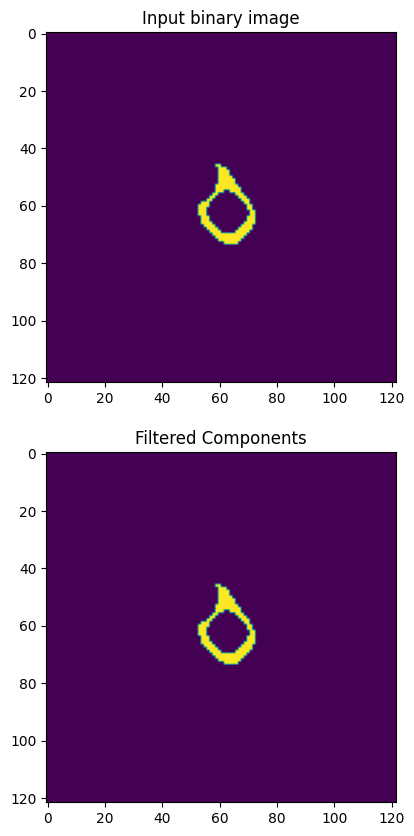

Total components: 2
Filtered components: 1


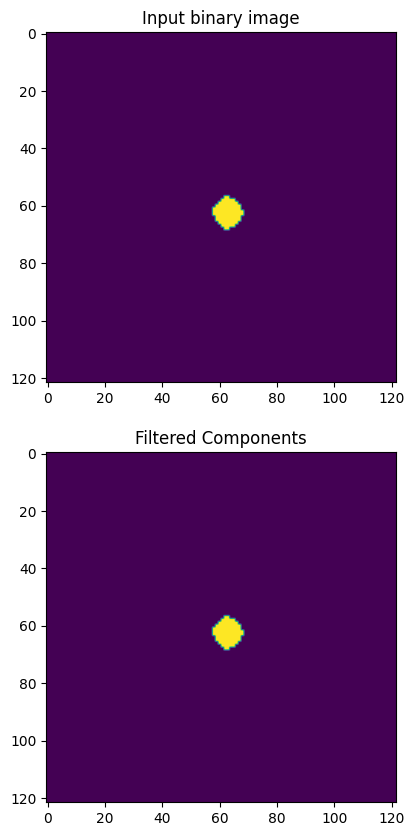

In [34]:
# Read image
ex_path = filtered_paths[0]
ex_img = cv2.imread(ex_path,0).astype(float)

# Segmentate to galaxy region and return center coordinates
print("SEGMENTATION")
cutout_img, xc, yc, _, _ = find_main_galaxy_center(ex_img, crop_x_ratio=0.29, crop_y_ratio=0.29, num_brightest_pixels=100, plot=True)


# Extract external descriptor
print("\nEXTERNAL DESCRIPTOR\n")
## Inspect clustering
bi_img = K_clustering(cutout_img, k=3, xc=xc, yc=yc, plot=True)
## Measure 
info = external_descriptor(bi_img, cutout_img, plot=True)

# Extract internal descriptor
print("\nINTERNAL DESCRIPTOR\n")
## Preprocessing
### Noise reduction
cutout_blur = noise_reduce(cutout_img, plot=True)
### Apply CLAHE histogram Equalization
cla_img = hist_equal(cutout_blur, adj_bright = -5, plot=True)

## Re-segmentate each region to binary images based on brightness
in_regions, cen_regions = multithreshold(cla_img, adj_thre0=50, adj_thre1=50, adj_thre2=60, plot=True)

## Post-processing
### Reduce small bright artifacts from the thresholding
mor_img_in = morph(in_regions, plot=True)
mor_img_cen = morph(cen_regions, plot=True)
### Perform iterative thinning for inner region (galaxy arms)
thinned_img, _ = mor_iter_thin(mor_img_in, structuring_elements, max_iterations=2, plot=True)

## Count connected components
### Count bright components surrounding center (arms (>2), smooth elliptical (~1))
_, filterLabels_in = mor_connect(thinned_img, min_area=100, max_area=3000, plot=True)
### Count centers (merging (>1))
_, filterLabels_cen = mor_connect(mor_img_cen, min_area=50, max_area=3000, plot=True)

## 4.2 Mass Extraction

In [35]:
# Create a pd dataframe
galaxy_df = process_images(filtered_paths)

In [36]:
galaxy_df

,FileName,K_Area,K_Perimeter,K_Orientation,K_Eccentricity,K_Solidity,Num_bright,Num_center
0,198489,3,3,0,0.816496580927726,1.0,1,1
1,115111,5723,323,0,0.8812674980194473,0.9709874448591789,1,1
2,217599,4187,285,1,0.8351878647416635,0.9318940574226575,1,1
3,248585,5658,328,0,0.7106350214678104,0.9415876185721418,1,1
4,63958,4820,292,0,0.7910775518894992,0.9563492063492064,1,1
...,...,...,...,...,...,...,...,...
995,199752,5443,403,0,0.5647608871125999,0.9296327924850555,1,1
996,191048,5151,370,0,0.6963639487845896,0.9067065657454674,1,1
997,81588,5716,344,0,0.7610170183861994,0.9533022014676451,1,1
998,234435,1,0,0,0,1.0,1,1


In [37]:
# Save dataframe as csv to notebook output
galaxy_df.to_csv('mini_gz2_info_update.csv', index=False)

print('Output file is successfully saved in Output')

Output file is successfully saved in Output
